# 다양한 접근 시도하는 노트북

In [1]:
# Library
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import sklearn
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgbm
from lightgbm import plot_importance, LGBMRegressor, early_stopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Fix Seed 
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(55) # Seed 고정

In [3]:
# Load Data
train_df = pd.read_csv('./open/train.csv')
train_x = train_df.filter(regex="X")
train_y = train_df.filter(regex="Y")

test = pd.read_csv("./open/test.csv").drop(columns='ID')

In [24]:
# LGBM 주요 변수 : X 03,05,07,08,09,49,50~56

train_x = train_x[['X_03', 'X_05', 'X_07', 'X_08', 'X_09',
                   'X_49', 'X_50', 'X_51', 'X_52', 'X_53',
                   'X_54', 'X_55', 'X_56']]

In [4]:
# Y_04(극도로 높은 평균신호대잡음비)
outlier_y4_idx = train_y[train_y['Y_04']>50].index

# Y_06(극히 낮은 신호대잡음비각도1)
outlier_y6_idx = train_y[train_y['Y_06']<0].index

# 이상치 확인 및 제거
outlier_idx = outlier_y6_idx.append(outlier_y4_idx)

train_y = train_y.drop(outlier_idx)
train_y.reset_index(drop=True, inplace=True)

train_x = train_x.drop(outlier_idx)
train_x.reset_index(drop=True, inplace=True)

train_x.shape, train_y.shape

((39507, 56), (39507, 14))

In [5]:
# Del useless feature("X_04", "X_23", "X_47", "X_48")
X_tr_std = pd.Series(np.std(train_x))
Del_idx = X_tr_std[X_tr_std==0].index

train_x = train_x.drop(columns=Del_idx)
test = test.drop(columns=Del_idx)

train_x.shape, test.shape

((39507, 52), (39608, 52))

In [14]:
# Data Split
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.3)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((27654, 52), (11853, 52), (27654, 14), (11853, 14))

In [9]:
# 평가 산식(NRMSE)
def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(0,14): # ignore 'ID'
        rmse = mean_squared_error(gt[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:15])
    return score

In [146]:
# Modeling
lgb = LGBMRegressor()
kfold = KFold(n_splits=5)

# 5 Cross validation
rmse_by_target = []
for i in range(train_y.shape[1]):
    cv_rmse = []
    num_iter = 0
    print("**Y_0{}_model**".format(i+1))
    
    for train_idx, val_idx in kfold.split(train_x):
        X_tr, X_val = train_x.iloc[train_idx, :], train_x.iloc[val_idx, :]
        y_tr, y_val = train_y.iloc[train_idx, i], train_y.iloc[val_idx, i]
        lgb.fit(X_tr, y_tr, verbose=True)
        y_pred = lgb.predict(X_val)    

        num_iter = num_iter + 1
        rmse = round(mean_squared_error(y_val, y_pred, squared=False), 4)
        
        print('Validation set{}, RMSE : {}'.format(num_iter, rmse))
        cv_rmse.append(rmse)
        print("mean of RMSE : {}".format(round(np.mean(cv_rmse),4)))
        
    rmse_by_target.append(np.mean(cv_rmse))
print(np.round(rmse_by_target,4))

**Y_01_model**
Validation set1, RMSE : 0.3597
mean of RMSE : 0.3597
Validation set2, RMSE : 0.343
mean of RMSE : 0.3514
Validation set3, RMSE : 0.3347
mean of RMSE : 0.3458
Validation set4, RMSE : 0.3463
mean of RMSE : 0.3459
Validation set5, RMSE : 0.3323
mean of RMSE : 0.3432
**Y_02_model**
Validation set1, RMSE : 0.3854
mean of RMSE : 0.3854
Validation set2, RMSE : 0.3695
mean of RMSE : 0.3774
Validation set3, RMSE : 0.3722
mean of RMSE : 0.3757
Validation set4, RMSE : 0.3788
mean of RMSE : 0.3765
Validation set5, RMSE : 0.3716
mean of RMSE : 0.3755
**Y_03_model**
Validation set1, RMSE : 0.3551
mean of RMSE : 0.3551
Validation set2, RMSE : 0.3436
mean of RMSE : 0.3494
Validation set3, RMSE : 0.3545
mean of RMSE : 0.3511
Validation set4, RMSE : 0.3612
mean of RMSE : 0.3536
Validation set5, RMSE : 0.35
mean of RMSE : 0.3529
**Y_04_model**
Validation set1, RMSE : 2.5732
mean of RMSE : 2.5732
Validation set2, RMSE : 2.4718
mean of RMSE : 2.5225
Validation set3, RMSE : 2.581
mean of RMSE

In [113]:
# Iterative Single Prediction
rmse_list = []
val_preds = []
test_preds = []

lgb = LGBMRegressor()
for i in range(y_train.shape[1]):
    evals=[(X_val, y_val.iloc[:,i])]
    lgb.fit(X_train, y_train.iloc[:,i], early_stopping_rounds=100,
            eval_metric='rmse', eval_set=evals, verbose=0)
    
    val_pred = lgb.predict(X_val)
    val_preds.append(val_pred)
    test_pred = lgb.predict(test)
    test_preds.append(test_pred)
    
    rmse = mean_squared_error(y_val.iloc[:,i], val_pred, squared=False)
    print(rmse)
    rmse_list.append(rmse)
print('Done.')

0.33970616857970815
0.370698077391988
0.3487151638072993
2.5303719445548842
2.4726608448976486
0.7580662157166128
0.3978425473708831
0.6199751286231894
0.6154825351031652
0.7733737202712406
0.7996672045150383
0.61701842915554
0.6163736518831753
0.6151641232884886
Done.


In [98]:
val_preds = pd.DataFrame(np.array(val_preds)).T
val_preds

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.471754,1.047779,1.071300,13.412467,31.488657,16.511143,3.335457,-26.308940,-26.275722,-22.195715,24.296417,-26.197156,-26.213460,-26.330510
1,1.292606,1.116728,0.988662,14.035085,30.373769,16.618390,3.142588,-26.255884,-26.273103,-22.321626,24.335324,-26.154122,-26.158540,-26.211250
2,1.303394,0.997917,0.892961,13.922202,31.076381,16.396361,3.096299,-26.270980,-26.343474,-22.330259,24.242795,-26.342945,-26.217641,-26.313047
3,1.462269,1.102964,1.071686,13.010290,30.859641,16.546252,3.261086,-26.200774,-26.293827,-22.064523,24.155232,-26.128976,-26.110129,-26.120733
4,1.333441,1.030264,1.008269,13.389735,31.209667,16.569279,3.172929,-26.501692,-26.451771,-22.405684,24.288263,-26.432975,-26.415409,-26.436021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11848,1.365842,1.018444,0.988830,13.903724,31.128178,16.599764,3.171423,-26.499134,-26.495925,-22.507078,24.252507,-26.414792,-26.390571,-26.482305
11849,1.532626,1.197470,1.153686,14.395007,31.949353,16.756232,3.139515,-26.067124,-26.060413,-22.192415,24.641810,-26.010012,-25.983171,-26.077739
11850,1.312616,0.916969,1.019940,13.026171,30.966403,16.753636,3.207469,-26.587218,-26.589706,-22.677786,24.370420,-26.438945,-26.579642,-26.554748
11851,1.481075,1.207401,1.116011,13.993614,32.101182,16.917771,3.020522,-26.129456,-26.072525,-22.094032,24.664752,-26.060339,-26.069384,-26.091309


In [114]:
test_preds = pd.DataFrame(np.array(test_preds)).T
test_preds

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.417044,1.199102,1.078182,13.916240,31.469010,16.669300,3.144319,-26.094471,-26.147608,-22.034466,24.501321,-26.064807,-26.119645,-25.956787
1,1.492962,1.195565,1.103913,13.095613,31.150372,16.675057,3.161329,-26.238266,-26.113069,-22.257657,24.377972,-26.053345,-26.081867,-26.070837
2,1.372370,1.086988,1.093406,15.016784,32.590986,17.068153,2.928201,-25.794993,-25.741306,-22.027628,24.945918,-25.712542,-25.649833,-25.824415
3,1.396603,1.097412,1.109112,15.130950,32.495698,17.216377,3.077174,-25.745558,-25.721064,-21.622099,25.039095,-25.707353,-25.674525,-25.641718
4,1.323691,1.037621,0.991854,15.243288,31.868446,16.897719,3.103721,-25.744047,-25.664371,-21.830834,24.738644,-25.604444,-25.516114,-25.727908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39603,1.268276,0.998926,0.947827,12.995947,30.759963,16.829618,3.175051,-26.361164,-26.333638,-22.769809,24.527476,-26.202697,-26.277003,-26.383930
39604,1.242563,0.868564,0.995227,13.685162,31.305514,16.724967,3.186197,-26.346270,-26.336648,-22.858121,24.642954,-26.316746,-26.257534,-26.296118
39605,1.314830,0.899203,1.089966,13.152086,31.634742,16.633756,3.159074,-26.439245,-26.404568,-23.004348,24.117459,-26.313387,-26.380851,-26.347055
39606,1.185085,0.827308,0.933217,13.285444,31.193952,16.859044,3.207543,-26.355562,-26.432990,-22.885031,24.579159,-26.403414,-26.305760,-26.352012


In [107]:
# 이상치 제거 후 LGBM 5-CV score
lg_nrmse(np.array(y_val), np.array(val_preds))

1.8424603093102867

In [121]:
submit = pd.read_csv('./open/sample_submission.csv')

for id, col in enumerate(submit.columns):
    if col=='ID':
        continue
    submit[col] = test_preds.iloc[:,id-1]
print('Done.')

Done.


In [122]:
submit.to_csv('./submit_rmv_outliers.csv',index=False)

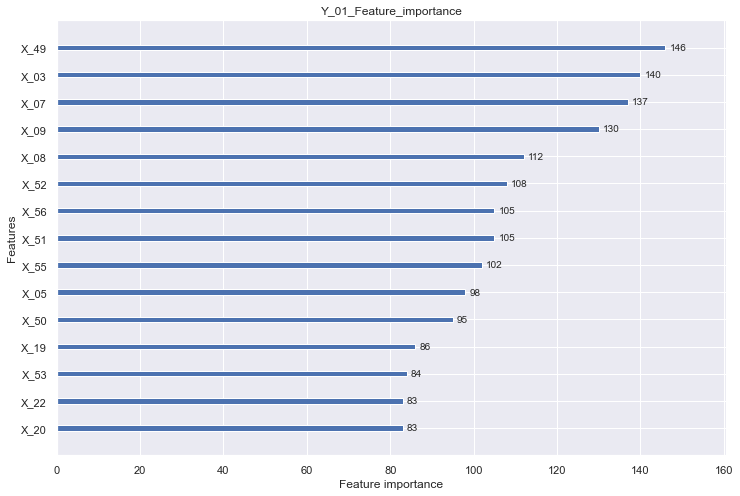

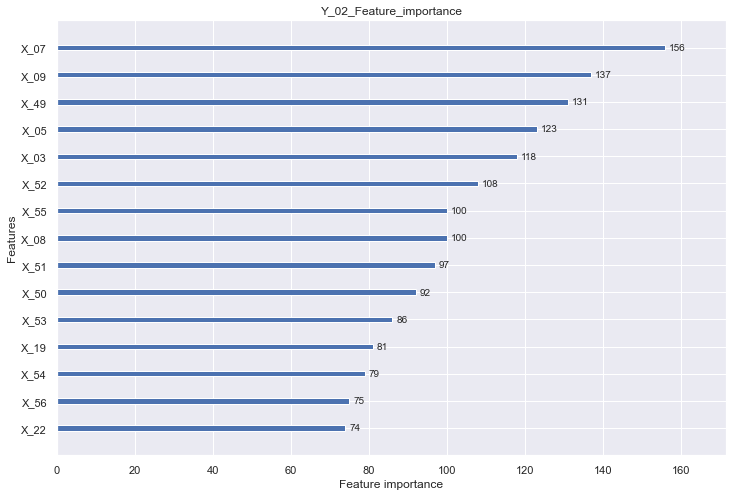

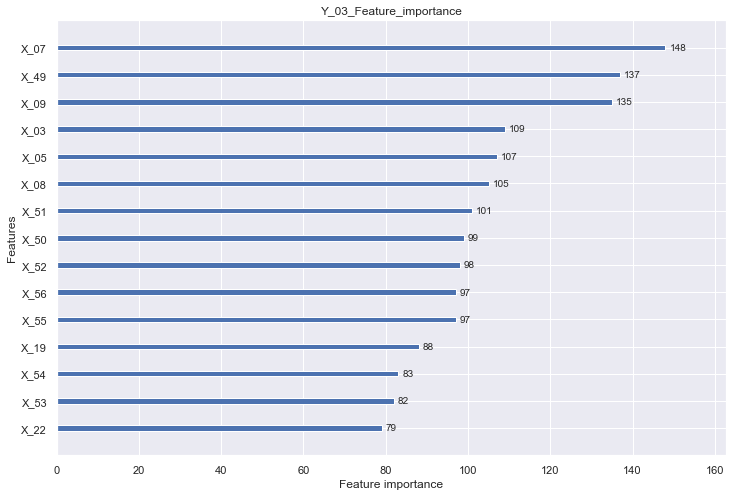

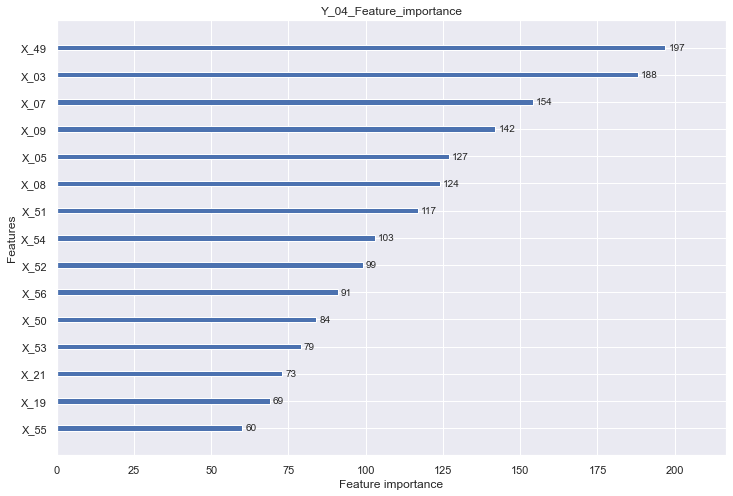

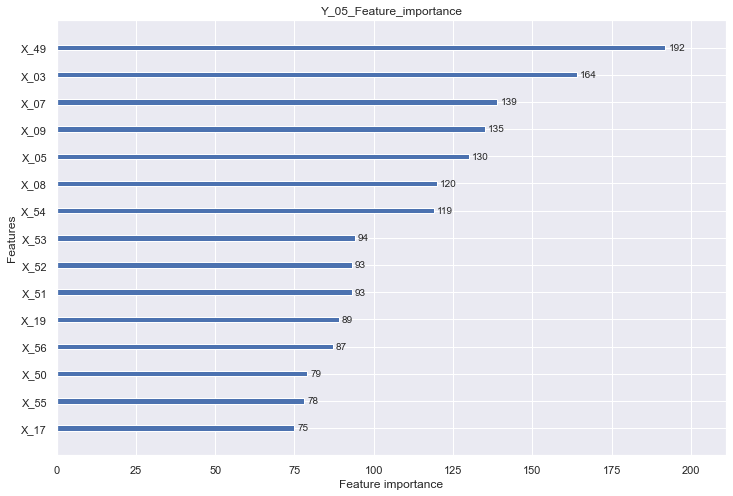

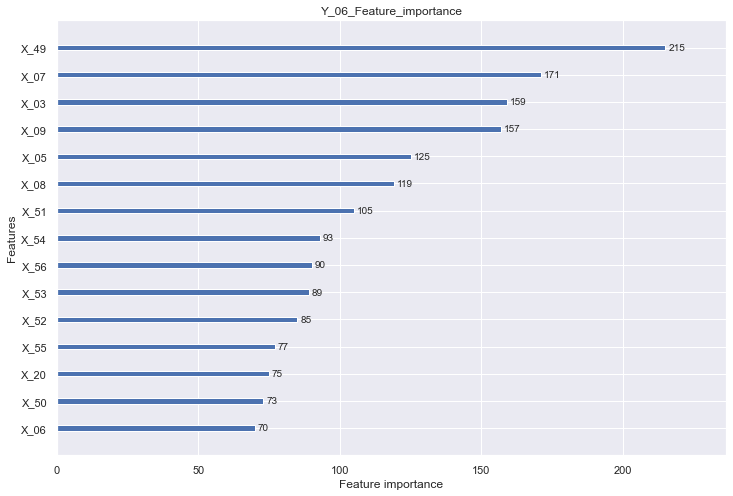

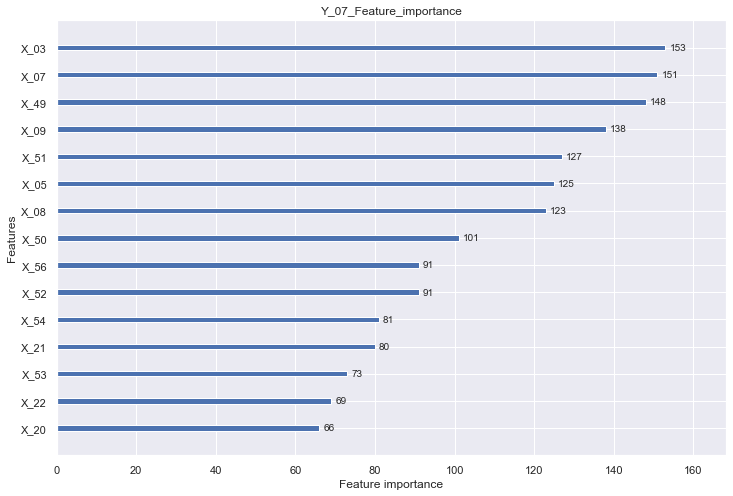

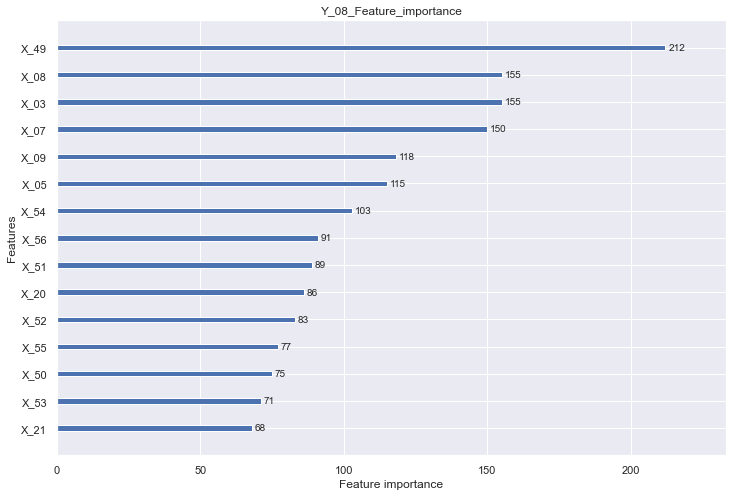

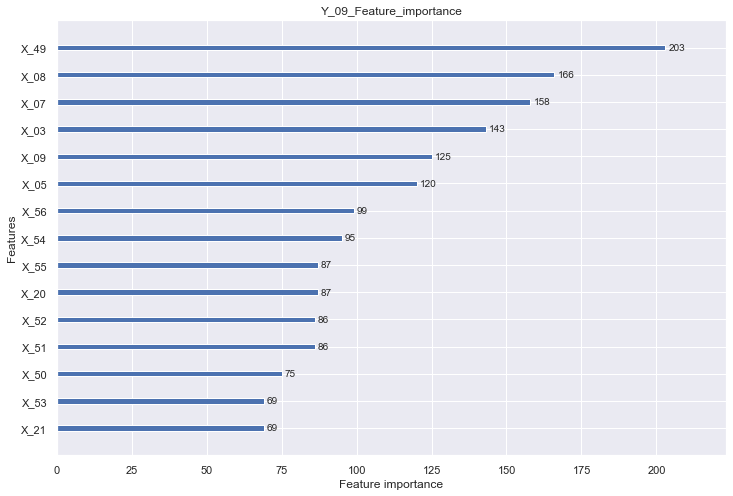

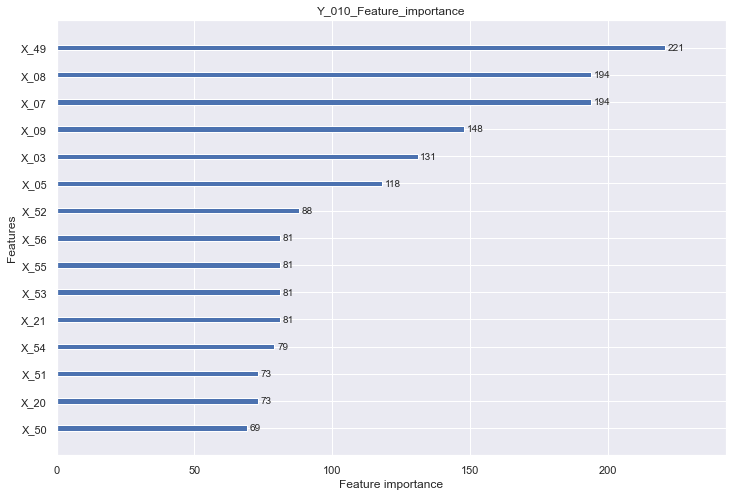

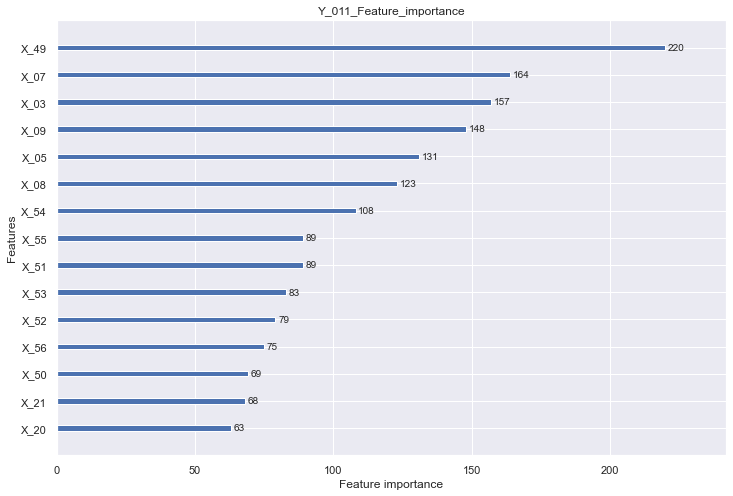

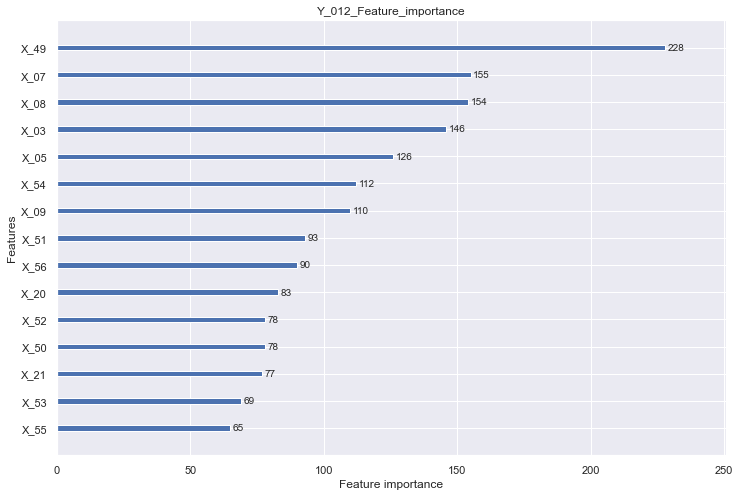

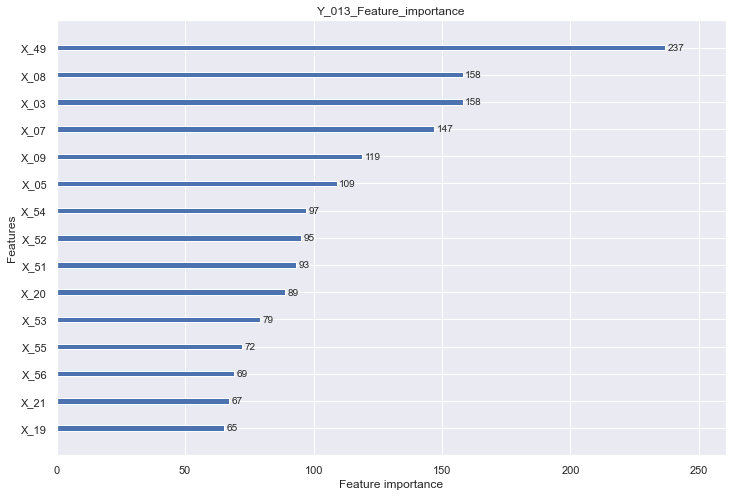

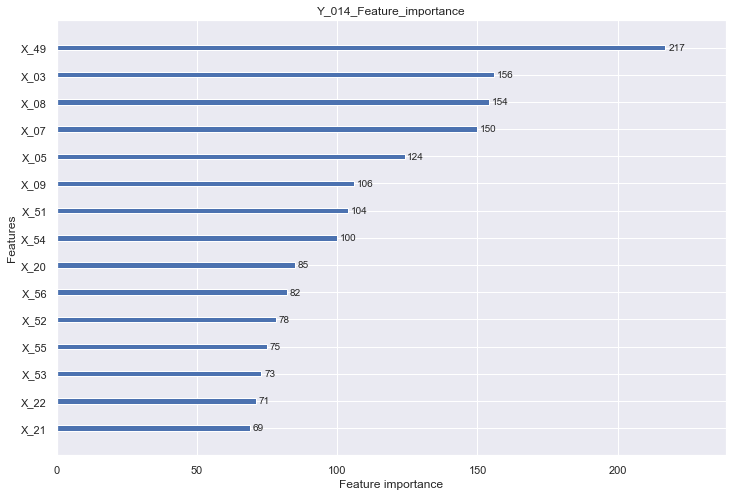

In [127]:
# LGBM 타겟별 변수중요도 (주요변수 X_03,05,07,08,09,20,49,50,51,52,53,54,55,56)
# 방열재료1무게&면적, 방열재료2&3면적, PCB체결누름량(step3), 스크류삽입깊이, SMT납량, cal투입전대기
for i in range(14):
    lgb.fit(train_x, train_y.iloc[:,i])
    plot_importance(lgb, max_num_features=15, title='Y_0{}_Feature_importance'.format(i+1),
                    figsize=(12,8))
    plt.show()